In [39]:
import numpy as np

# Your data
x = np.arange(4000, 9000, 10)  # lambda values
y = np.random.randn(len(x))  # data points

# Specify bin width in x-units
bin_width = 50

# Step 1: Calculate the step size between x values
step_size = np.median(np.diff(x)) # x[1] - x[0]  # e.g., 10

# Step 2: Calculate how many points fit in each bin
points_per_bin = int(bin_width / step_size)  # e.g., 50/10 = 5

print(f"Step size: {step_size}")
print(f"Bin width: {bin_width}")
print(f"Points per bin: {points_per_bin}")

# Step 3: Calculate complete bins
n_complete_bins = len(y) // points_per_bin
n_points_to_keep = n_complete_bins * points_per_bin

# Step 4: Trim and reshape
y_2d = y[:n_points_to_keep].reshape(n_complete_bins, points_per_bin)
x_2d = x[:n_points_to_keep].reshape(n_complete_bins, points_per_bin)

# Step 5: Take median of each bin
y_binned = np.median(y_2d, axis=1)
x_binned = np.median(x_2d, axis=1)

Step size: 10.0
Bin width: 50
Points per bin: 5


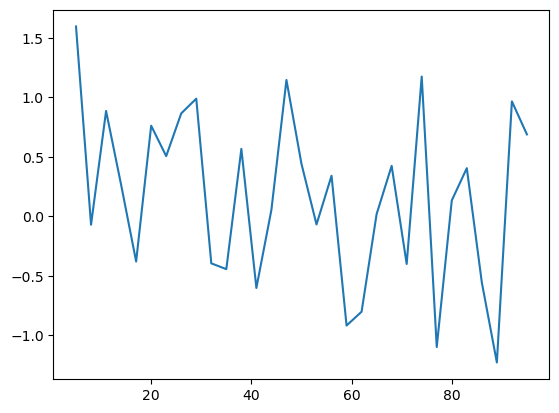

6
90
31
31
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False]


ValueError: cannot reshape array of size 31 into shape (6,newaxis)

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Your original data
x = np.arange(5, 97, 3)  # lambda values
y = np.random.randn(len(x))  # data points

plt.plot(x, y)
plt.show()

bin_width = 15

num_bins = (np.nanmax(x) - np.nanmin(x)) // bin_width

print(num_bins)
print(num_bins*bin_width)
print(len(x))
print(len(y))

x_filled = np.full(shape=len(x), fill_value=np.nan)
mask = np.full(len(x), True, dtype=bool)
mask[len(x)-1:] = False

print(x_filled)
print(mask)



x2d = x.reshape(num_bins, -1)
y2d = y.reshape(num_bins, -1)





In [ ]:
# Fixed version of gaussian_blur_to_match_fwhm
from scipy.ndimage import gaussian_filter1d

def gaussian_blur_to_match_fwhm(
    low_res: np.ndarray | float, 
    high_res: np.ndarray | float, 
    lam: np.ndarray,
    flux_highres: np.ndarray, 
    wavelength_step: float, 
    n_chunks: int = 20
) -> np.ndarray:
    """
    Gaussian blur using resolution (R = λ/FWHM) arrays.
    Degrades high_res spectrum to match low_res spectrum.
    
    Handles the case where high_res <= low_res at some wavelengths
    (no blurring needed there).
    """
    if np.isscalar(low_res):
        low_res = np.full_like(lam, low_res)
    if np.isscalar(high_res):
        high_res = np.full_like(lam, high_res)

    fwhm_lowres = lam / low_res
    fwhm_highres = lam / high_res

    sigma_lowres = fwhm_lowres / 2.355
    sigma_highres = fwhm_highres / 2.355
    
    # Calculate the kernel sigma needed to convolve high_res to low_res
    # If high_res is already lower resolution, no blurring needed (set to 0)
    sigma_diff_sq = sigma_lowres**2 - sigma_highres**2
    sigma_diff_sq = np.maximum(sigma_diff_sq, 0)  # Clamp negative values to 0
    sigma_kernel_arr = np.sqrt(sigma_diff_sq)
    
    blurred = flux_highres.copy()  # Start with original flux
    chunk_size = len(lam) // n_chunks
    
    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_chunks - 1 else len(lam)
        
        sigma_pix = np.median(sigma_kernel_arr[start:end]) / wavelength_step
        
        # Only blur if sigma is meaningful (> small threshold)
        if sigma_pix > 0.1:  # Skip if essentially no blurring needed
            temp_blurred = gaussian_filter1d(flux_highres, sigma=sigma_pix)
            blurred[start:end] = temp_blurred[start:end]
        # else: keep original flux (already copied above)
    
    return blurred